In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## EDA

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

print("Loading the RefCOCOg dataset...")

Loading the RefCOCOg dataset...


In [2]:
# Load the instances.json file
with open('/kaggle/input/refcocog-small/instances.json', 'r') as f:
    data = json.load(f)

print(f"Data loaded successfully. Exploring structure...")

Data loaded successfully. Exploring structure...


In [3]:
# Print the structure of the JSON data
print(f"\nKeys in the JSON data: {list(data.keys())}")


Keys in the JSON data: ['info', 'licenses', 'images', 'annotations', 'categories']


In [4]:
# Explore the data structure
for key in data.keys():
    if isinstance(data[key], list):
        print(f"\n{key}: List with {len(data[key])} items")
        if len(data[key]) > 0:
            print(f"Sample item: {data[key][0]}")
    elif isinstance(data[key], dict):
        print(f"\n{key}: Dictionary with {len(data[key])} items")
        if len(data[key]) > 0:
            first_key = list(data[key].keys())[0]
            print(f"Sample item: {first_key}: {data[key][first_key]}")


info: Dictionary with 6 items
Sample item: description: This is stable 1.0 version of the 2014 MS COCO dataset.

licenses: List with 8 items
Sample item: {'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/', 'id': 1, 'name': 'Attribution-NonCommercial-ShareAlike License'}

images: List with 1400 items
Sample item: {'license': 3, 'file_name': 'COCO_train2014_000000187540.jpg', 'coco_url': 'http://mscoco.org/images/187540', 'height': 489, 'width': 640, 'date_captured': '2013-11-16 18:33:43', 'flickr_url': 'http://farm3.staticflickr.com/2730/4520701091_70873d4f29_z.jpg', 'id': 187540}

annotations: List with 11430 items
Sample item: {'segmentation': [[458.78, 253.91, 468.4, 241.41, 559.77, 249.11, 559.77, 91.37, 445.31, 77.91, 442.43, 237.56, 453.01, 251.99, 455.89, 255.84], [593.43, 99.07, 640.0, 130.8, 640.0, 193.32, 629.02, 193.32, 616.51, 250.07, 615.55, 214.48, 608.82, 206.79, 599.2, 210.63, 597.28, 213.52, 594.39, 213.52, 601.12, 255.84, 589.58, 250.07, 593.43, 100.03]], 'ar

In [5]:
# Function to extract meaningful statistics from the dataset
def analyze_refcocog(data):
    results = {}
    
    # Analyze images
    if 'images' in data:
        image_data = pd.DataFrame(data['images'])
        results['total_images'] = len(image_data)
        results['image_size_stats'] = {
            'width': {
                'mean': image_data['width'].mean() if 'width' in image_data.columns else 'N/A',
                'min': image_data['width'].min() if 'width' in image_data.columns else 'N/A',
                'max': image_data['width'].max() if 'width' in image_data.columns else 'N/A'
            },
            'height': {
                'mean': image_data['height'].mean() if 'height' in image_data.columns else 'N/A',
                'min': image_data['height'].min() if 'height' in image_data.columns else 'N/A',
                'max': image_data['height'].max() if 'height' in image_data.columns else 'N/A'
            }
        }
        
        if 'file_name' in image_data.columns:
            results['image_extensions'] = Counter([os.path.splitext(fn)[1] for fn in image_data['file_name'] if isinstance(fn, str)])
    
    # Analyze annotations
    if 'annotations' in data:
        annot_data = pd.DataFrame(data['annotations'])
        results['total_annotations'] = len(annot_data)
        
        if 'area' in annot_data.columns:
            results['annotation_area_stats'] = {
                'mean': annot_data['area'].mean(),
                'min': annot_data['area'].min(),
                'max': annot_data['area'].max()
            }
        
        if 'bbox' in annot_data.columns:
            bbox_data = pd.DataFrame(annot_data['bbox'].tolist(), columns=['x', 'y', 'width', 'height'])
            results['bbox_stats'] = {
                'width': {
                    'mean': bbox_data['width'].mean(),
                    'min': bbox_data['width'].min(),
                    'max': bbox_data['width'].max()
                },
                'height': {
                    'mean': bbox_data['height'].mean(),
                    'min': bbox_data['height'].min(),
                    'max': bbox_data['height'].max()
                }
            }
        
        if 'category_id' in annot_data.columns:
            results['category_distribution'] = Counter(annot_data['category_id'])
    
    # Analyze categories
    if 'categories' in data:
        cat_data = pd.DataFrame(data['categories'])
        results['total_categories'] = len(cat_data)
        if 'name' in cat_data.columns:
            results['category_names'] = cat_data['name'].tolist()
    
    # Analyze referring expressions
    if 'sentences' in data:
        sent_data = pd.DataFrame(data['sentences'])
        results['total_sentences'] = len(sent_data)
        
        if 'sent_id' in sent_data.columns and 'tokens' in sent_data.columns:
            # Calculate sentence lengths
            sent_data['sent_length'] = sent_data['tokens'].apply(lambda x: len(x) if isinstance(x, list) else 0)
            results['sentence_length_stats'] = {
                'mean': sent_data['sent_length'].mean(),
                'min': sent_data['sent_length'].min(),
                'max': sent_data['sent_length'].max()
            }
            
            # Get vocabulary statistics if tokens are available
            all_tokens = []
            for tokens in sent_data['tokens']:
                if isinstance(tokens, list):
                    all_tokens.extend(tokens)
            
            results['vocabulary_size'] = len(set(all_tokens))
            results['top_20_words'] = Counter(all_tokens).most_common(20)
    
    return results

# Analyze the data
analysis_results = analyze_refcocog(data)

In [6]:
# Print analysis results
print("\n==== RefCOCOg Dataset Analysis ====")
for key, value in analysis_results.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"  {value}")


==== RefCOCOg Dataset Analysis ====

total_images:
  1400

image_size_stats:
  width: {'mean': 583.7514285714286, 'min': 281, 'max': 640}
  height: {'mean': 481.30571428571426, 'min': 199, 'max': 640}

image_extensions:
  .jpg: 1400

total_annotations:
  11430

annotation_area_stats:
  mean: 13837.82105923447
  min: 2.425500000000009
  max: 401793.5143999999

bbox_stats:
  width: {'mean': 120.13484689413822, 'min': 0.95, 'max': 640.0}
  height: {'mean': 124.73046019247596, 'min': 1.67, 'max': 640.0}

category_distribution:
  3: 484
  1: 2919
  88: 87
  31: 163
  77: 112
  6: 75
  8: 130
  14: 18
  72: 109
  63: 164
  75: 147
  84: 422
  67: 354
  49: 151
  61: 117
  51: 264
  48: 147
  36: 27
  65: 41
  44: 387
  70: 30
  34: 29
  41: 59
  33: 62
  5: 73
  9: 81
  24: 110
  54: 118
  58: 56
  4: 95
  28: 103
  62: 769
  35: 70
  32: 72
  37: 70
  43: 43
  42: 50
  47: 441
  27: 152
  85: 42
  86: 125
  38: 37
  16: 83
  74: 30
  76: 44
  55: 88
  19: 57
  22: 69
  21: 78
  7: 47
  10:

In [7]:
# Create visualizations based on the data structure
print("\n==== Generating Visualizations ====")


==== Generating Visualizations ====


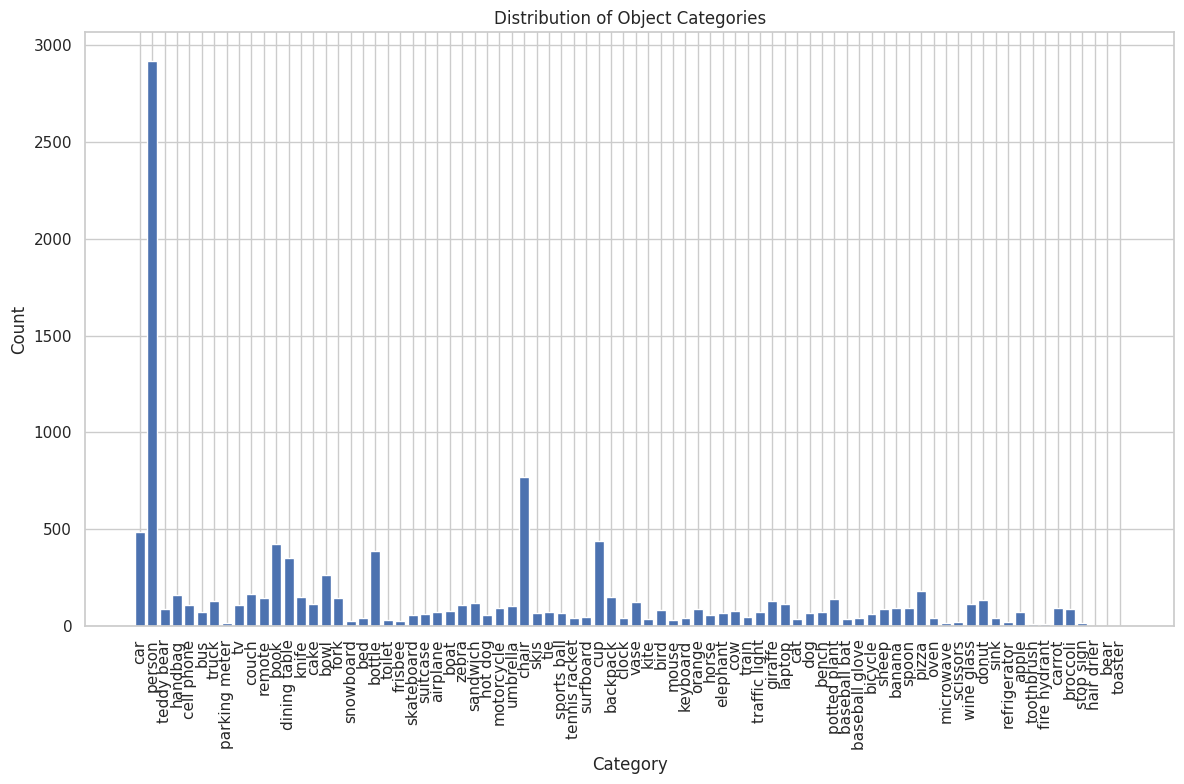

In [10]:
# Visualization : Category distribution (if available)
if 'annotations' in data and 'category_id' in pd.DataFrame(data['annotations']).columns:
    category_counts = Counter([anno['category_id'] for anno in data['annotations']])
    categories = {}
    if 'categories' in data:
        categories = {cat['id']: cat['name'] for cat in data['categories']}
    
    labels = [categories.get(cat_id, str(cat_id)) for cat_id in category_counts.keys()]
    
    plt.figure(figsize=(12, 8))
    plt.bar(labels, category_counts.values())
    plt.title('Distribution of Object Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


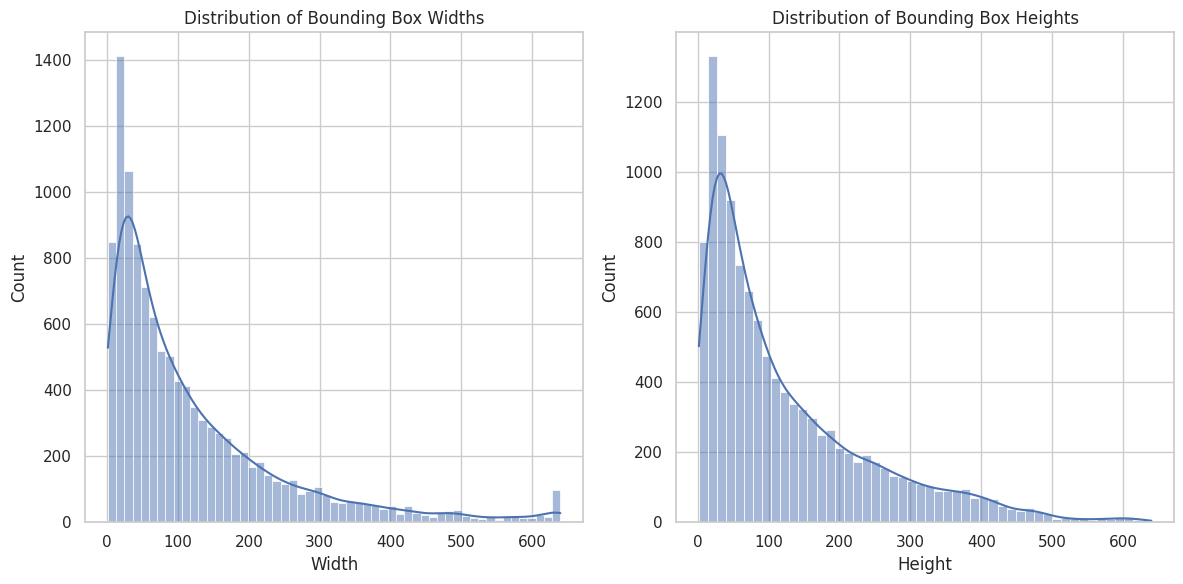

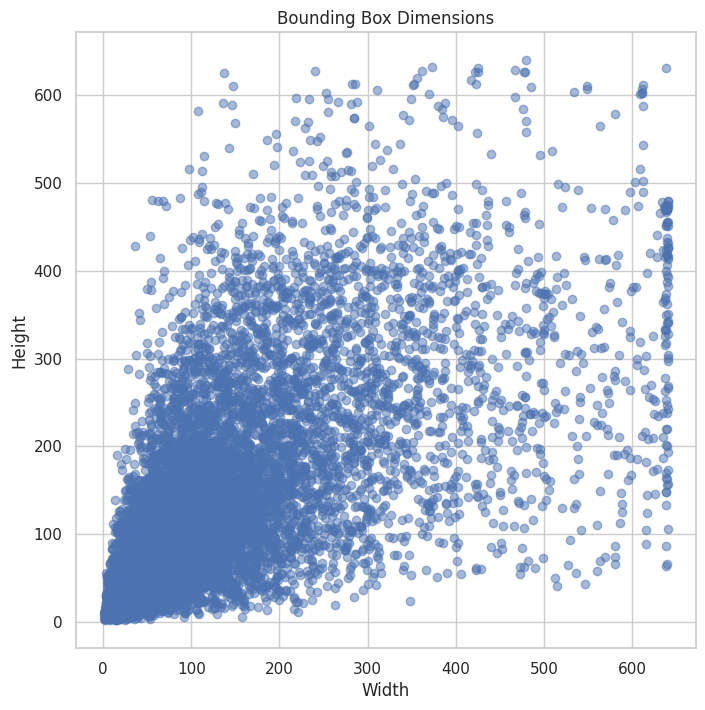


EDA completed!


In [12]:
# Visualization : Bounding box dimensions (if available)
if 'annotations' in data and 'bbox' in pd.DataFrame(data['annotations']).columns:
    bboxes = [anno['bbox'] for anno in data['annotations']]
    if bboxes and len(bboxes[0]) >= 4:  # Check if bbox has at least 4 elements [x, y, width, height]
        widths = [bbox[2] for bbox in bboxes]
        heights = [bbox[3] for bbox in bboxes]
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(widths, kde=True)
        plt.title('Distribution of Bounding Box Widths')
        plt.xlabel('Width')
        
        plt.subplot(1, 2, 2)
        sns.histplot(heights, kde=True)
        plt.title('Distribution of Bounding Box Heights')
        plt.xlabel('Height')
        
        plt.tight_layout()
        plt.show()
        
        # Scatter plot of width vs height
        plt.figure(figsize=(8, 8))
        plt.scatter(widths, heights, alpha=0.5)
        plt.title('Bounding Box Dimensions')
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.grid(True)
        plt.show()

print("\nEDA completed!")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


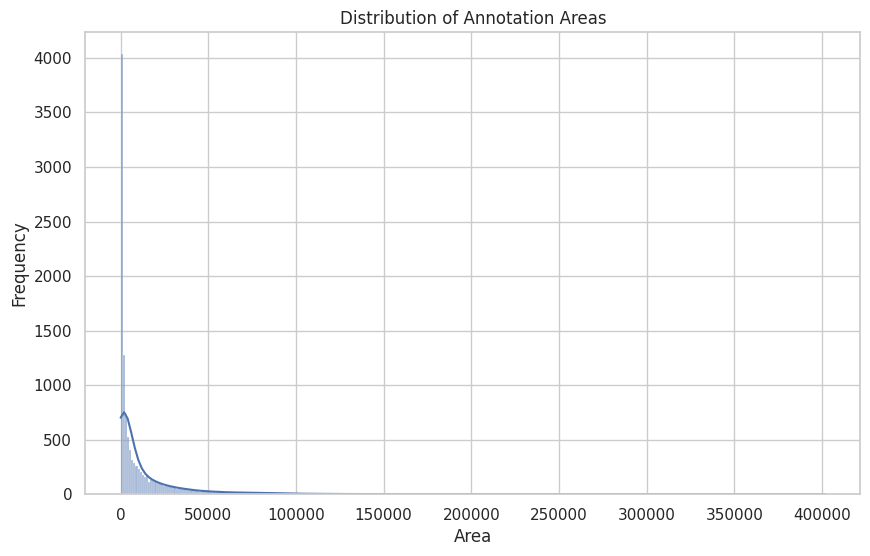

In [8]:
# Visualization : Distribution of annotation areas (if available)
if 'annotations' in data and 'area' in pd.DataFrame(data['annotations']).columns:
    areas = [anno['area'] for anno in data['annotations']]
    plt.figure(figsize=(10, 6))
    sns.histplot(areas, kde=True)
    plt.title('Distribution of Annotation Areas')
    plt.xlabel('Area')
    plt.ylabel('Frequency')
    plt.show()


📘 google Split:
  Total Samples: 2735
  Avg. Sentence Length: 8.43 words
  Avg. BBox Area: 56598.68 px²
  Avg. Relative Area: 20.44%


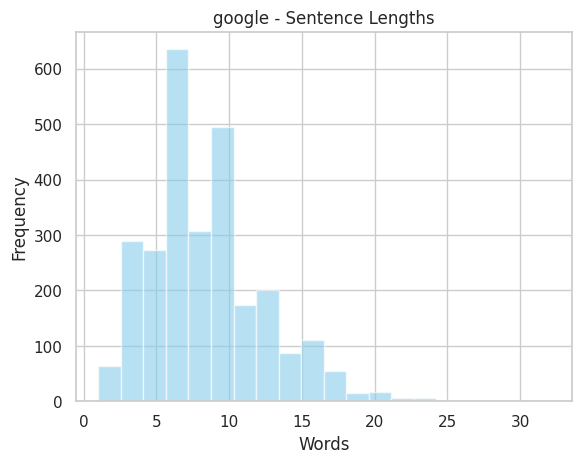

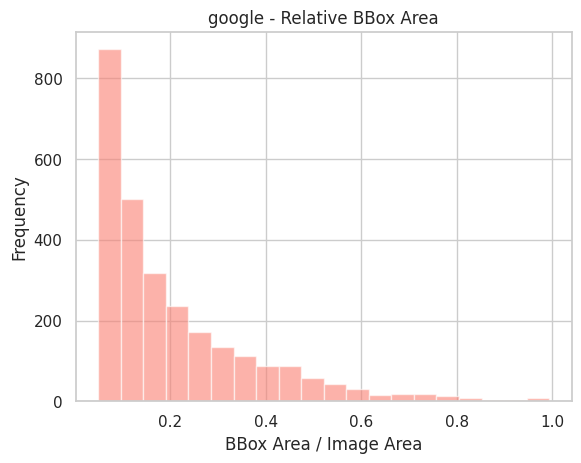

📘 umd Split:
  Total Samples: 2735
  Avg. Sentence Length: 8.43 words
  Avg. BBox Area: 56598.68 px²
  Avg. Relative Area: 20.44%


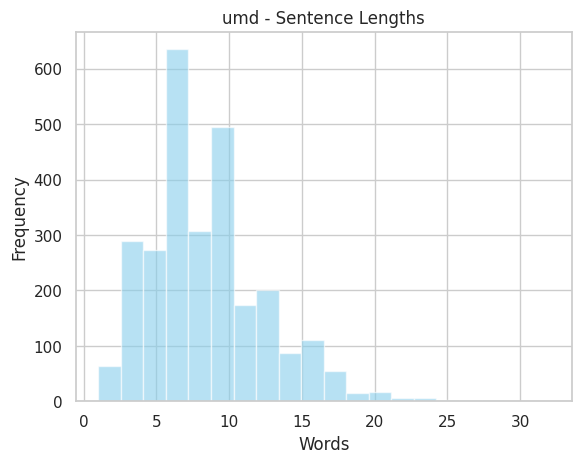

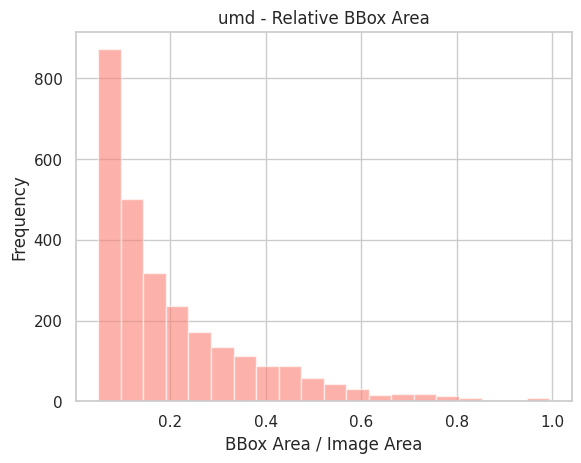

In [16]:
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt

# Load mini refs
with open('/kaggle/input/refcocog-small/refs(google).p', 'rb') as f:
    google_refs = pickle.load(f)

with open('/kaggle/input/refcocog-small/refs(umd).p', 'rb') as f:
    umd_refs = pickle.load(f)

with open('/kaggle/input/refcocog-small/instances.json', 'r') as f:
    instances = json.load(f)

# Map ann_id to bbox
ann_id_to_bbox = {ann['id']: ann['bbox'] for ann in instances['annotations']}
img_id_to_size = {img['id']: (img['width'], img['height']) for img in instances['images']}

def analyze_refs(refs, split_name):
    lengths = []
    areas = []
    relative_areas = []

    for ref in refs:
        sentence = ref['sentences'][0]['sent']
        lengths.append(len(sentence.split()))

        bbox = ann_id_to_bbox.get(ref['ann_id'], [0, 0, 0, 0])
        area = bbox[2] * bbox[3]
        areas.append(area)

        img_size = img_id_to_size.get(ref['image_id'], (1, 1))
        rel_area = area / (img_size[0] * img_size[1])
        relative_areas.append(rel_area)

    print(f"📘 {split_name} Split:")
    print(f"  Total Samples: {len(refs)}")
    print(f"  Avg. Sentence Length: {np.mean(lengths):.2f} words")
    print(f"  Avg. BBox Area: {np.mean(areas):.2f} px²")
    print(f"  Avg. Relative Area: {np.mean(relative_areas)*100:.2f}%")

    # Histogram of sentence lengths
    plt.hist(lengths, bins=20, alpha=0.6, color='skyblue')
    plt.title(f"{split_name} - Sentence Lengths")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

    # Histogram of relative areas
    plt.hist(relative_areas, bins=20, alpha=0.6, color='salmon')
    plt.title(f"{split_name} - Relative BBox Area")
    plt.xlabel("BBox Area / Image Area")
    plt.ylabel("Frequency")
    plt.show()

# Run for both splits
analyze_refs(google_refs, "google")
analyze_refs(umd_refs, "umd")


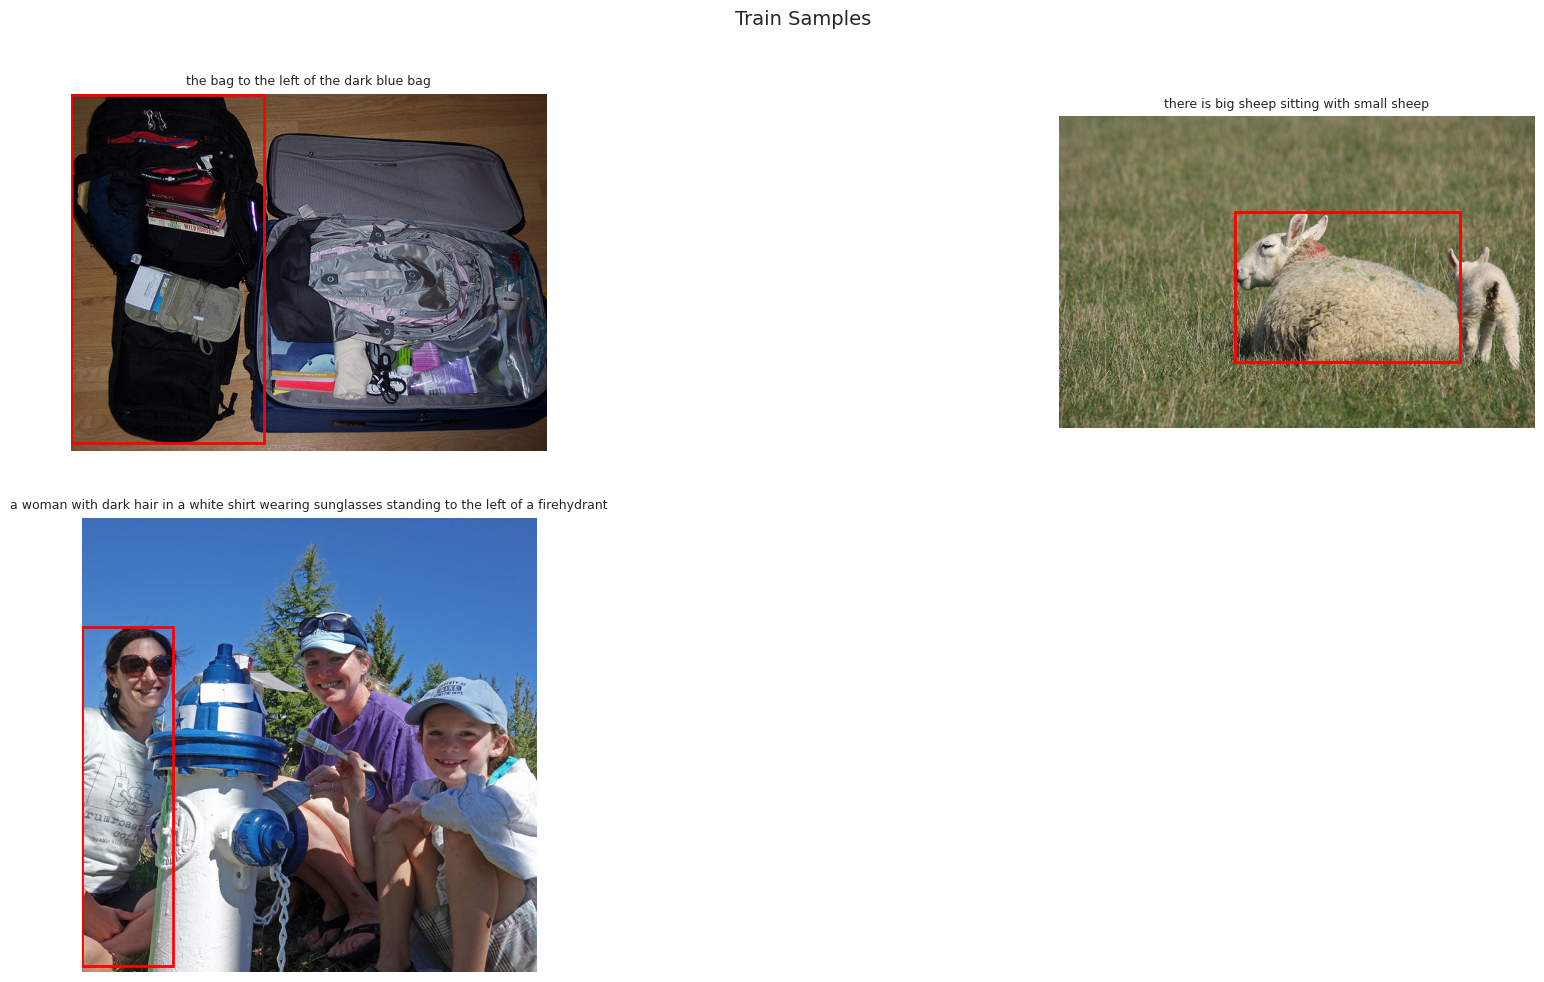

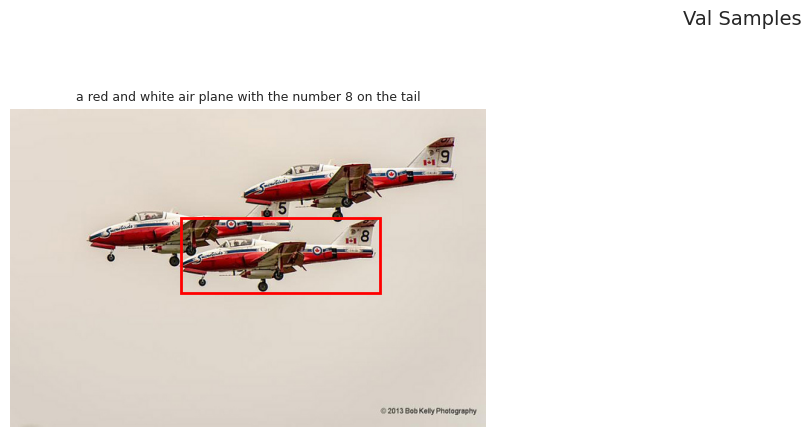

In [19]:
import random
import matplotlib.patches as patches
from PIL import Image
import os

def visualize_samples(refs, num_samples, img_folder, title="Sample Visualization"):
    sample_refs = random.sample(refs, num_samples)
    plt.figure(figsize=(15, 5 * ((num_samples + 2) // 3)))
    
    for i, ref in enumerate(sample_refs):
        img_id = ref['image_id']
        ann_id = ref['ann_id']
        sentence = ref['sentences'][0]['sent']
        fname = img_id_to_file[img_id]
        img_path = os.path.join(img_folder, fname)
        
        if not os.path.exists(img_path):
            continue

        image = Image.open(img_path).convert("RGB")
        bbox = ann_id_to_bbox[ann_id]

        ax = plt.subplot((num_samples + 2) // 3, 3, i + 1)
        ax.imshow(image)
        ax.set_title(f"{sentence}", fontsize=9)
        ax.axis('off')

        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Load COCO image info to map image_id → filename
with open('/kaggle/input/refcocog-small/instances.json', 'r') as f:
    instances = json.load(f)

# Create image_id → file_name mapping
img_id_to_file = {img['id']: img['file_name'] for img in instances['images']}

# Also make sure you have:
ann_id_to_bbox = {ann['id']: ann['bbox'] for ann in instances['annotations']}

# Example usage
visualize_samples(train_refs, num_samples=4, img_folder='/kaggle/input/train-refcoco', title="Train Samples")
visualize_samples(val_refs, num_samples=2, img_folder='/kaggle/input/val-refcoco', title="Val Samples")


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


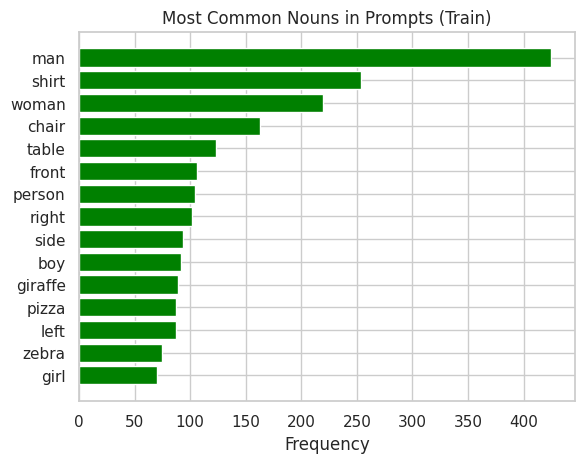

In [20]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')


def get_noun_freq(refs):
    noun_counter = Counter()
    for ref in refs:
        sent = ref['sentences'][0]['sent']
        tokens = nltk.word_tokenize(sent)
        pos_tags = nltk.pos_tag(tokens)
        nouns = [word.lower() for word, tag in pos_tags if tag.startswith('NN')]
        noun_counter.update(nouns)
    return noun_counter

# Run on train refs
noun_freq = get_noun_freq(train_refs)

# Plot top 15 nouns
top_nouns = noun_freq.most_common(15)
labels, values = zip(*top_nouns)
plt.barh(labels, values, color='green')
plt.gca().invert_yaxis()
plt.title("Most Common Nouns in Prompts (Train)")
plt.xlabel("Frequency")
plt.show()
